In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.preprocessing.image import ImageDataGenerator


Using TensorFlow backend.


In [3]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.callbacks import EarlyStopping, History, ModelCheckpoint
from keras.layers.core import Flatten, Dense, Dropout, Reshape, Lambda
from keras.layers.normalization import BatchNormalization


In [4]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

In [5]:
import numpy as np

In [6]:
#train_features = np.load('train_preprocesed.npy')
valid_features = np.load('valid_preprocessed.npy')

In [7]:
train_dir = "new_train/"
valid_dir = "new_valid/"

In [8]:
classes = os.listdir(train_dir)

In [9]:
# Get the labels

train_labels = []
for c in classes:
    l = [c]*len(os.listdir(train_dir+c+'/'))
    train_labels.extend(l)
    

In [10]:
len(train_labels)

3019

In [11]:
valid_labels = []

for c in classes:
    l = [c]*len(os.listdir(valid_dir+c+'/'))
    valid_labels.extend(l)

In [12]:
onehot_train = to_categorical(LabelEncoder().fit_transform(train_labels))

In [13]:
onehot_valid = to_categorical(LabelEncoder().fit_transform(valid_labels))

In [14]:
vgg16_base = VGG16(include_top=False, weights='imagenet',
                    input_tensor=None, input_shape=(150, 150,3))
# Note that the preprocessing of InceptionV3 is:
# (x / 255 - 0.5) x 2

print('Adding new layers...')
output = vgg16_base.get_layer(index = -1).output  
output = Flatten()(output)
# let's add a fully-connected layer
output = Dense(4096,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
output = Dense(512,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
# and a logistic layer -- let's say we have 200 classes
output = Dense(8, activation='softmax')(output)


vgg16_model = Model(vgg16_base.input, output)
#InceptionV3_model.summary()


Adding new layers...


In [15]:
for layer in vgg16_model.layers[:19]:
    layer.trainable = False

In [16]:

vgg16_model.compile(optimizer="adam",loss="categorical_crossentropy",metrics =["accuracy"])

In [18]:
vgg16_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 150, 150, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 150, 150, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 150, 150, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 75, 75, 64)    0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [17]:
train_datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        rotation_range=10.,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True)


val_datagen = ImageDataGenerator()



In [18]:
callbacks = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')        
# autosave best Model
best_model_file = "./data_augmented_weights.h5"
best_model = ModelCheckpoint(best_model_file, monitor='val_acc', verbose = 1, save_best_only = True)

In [39]:
history = vgg16_model.fit_generator(train_datagen.flow(train_features, onehot_train, batch_size=10), nb_epoch=5,
              samples_per_epoch = 3019,                     
              validation_data=val_datagen.flow(valid_features,onehot_valid,batch_size=10,shuffle=False),
                                    nb_val_samples=758,callbacks = [callbacks,best_model])


Epoch 1/10


KeyboardInterrupt: 

In [17]:
#model.load_weights("batch_normalized_weights.h5")
vgg16_model.load_weights("data_augmented_weights.h5")

In [19]:
valid_preds = vgg16_model.predict(valid_features, batch_size=5, verbose=1)

758/758 [==============================] - 544s     

In [20]:
np.save("valid_preds.npy",valid_preds)

In [21]:
valid_preds[0:5]

array([[  7.59789944e-02,   8.01078618e-01,   5.65482878e-05,
          1.54808040e-05,   2.63032533e-04,   3.95106443e-04,
          1.53965266e-05,   1.22196853e-01],
       [  9.98006284e-01,   3.96767464e-05,   2.04787993e-05,
          1.39258291e-05,   1.68402237e-03,   7.59936302e-05,
          9.07040376e-05,   6.90260422e-05],
       [  1.90550789e-01,   1.06245549e-02,   8.72172695e-03,
          7.24356398e-02,   2.47095653e-04,   2.52160907e-01,
          4.43342984e-01,   2.19162963e-02],
       [  9.80432391e-01,   6.52207411e-04,   1.30748311e-02,
          3.64251144e-04,   3.48607777e-03,   1.10439211e-03,
          1.92419742e-04,   6.93422859e-04],
       [  9.96160746e-01,   6.72668830e-05,   1.94042768e-05,
          2.68389937e-04,   2.57409320e-05,   3.16330977e-03,
          1.93627304e-04,   1.01566664e-04]], dtype=float32)

In [22]:
valid_pred_df = pd.DataFrame(valid_preds, columns= os.listdir(train_dir))


In [23]:
valid_pred_df.head()

,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,0.075979,0.801079,0.000057,0.000015,0.000263,0.000395,0.000015,0.122197
1,0.998006,0.000040,0.000020,0.000014,0.001684,0.000076,0.000091,0.000069
2,0.190551,0.010625,0.008722,0.072436,0.000247,0.252161,0.443343,0.021916
3,0.980432,0.000652,0.013075,0.000364,0.003486,0.001104,0.000192,0.000693
4,0.996161,0.000067,0.000019,0.000268,0.000026,0.003163,0.000194,0.000102


In [38]:
rounded_labels = valid_pred_df.round()

In [39]:
rounded_labels.head()

,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
np_valid_preds = valid_preds

In [295]:
rounded_preds = np_valid_preds.round()

In [42]:
from sklearn.metrics import accuracy_score

In [45]:
accuracy_score(onehot_valid,rounded_preds)

0.84828496042216361

In [48]:
from sklearn.preprocessing import LabelEncoder


In [49]:
encoder = LabelEncoder()

In [50]:
encoder.fit(classes)

LabelEncoder()

In [54]:
rounded_labels.to_csv("validation_predictions.csv")

In [57]:
rows = [] 
for row in rounded_labels.head().itertuples():
    rows.append(row)

In [62]:
rows[2][]

Pandas(Index=2, ALB=0.0, BET=0.0, DOL=0.0, LAG=0.0, NoF=0.0, OTHER=0.0, SHARK=0.0, YFT=0.0)

In [88]:
our_labels = valid_pred_df.round(1)

In [89]:
our_labels[0:20]

,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,0.1,0.8,0.0,0.0,0.0,0.0,0.0,0.1
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.2,0.0,0.0,0.1,0.0,0.3,0.4,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.9,0.0,0.0,0.0,0.1,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.6,0.0,0.0,0.0,0.4,0.0,0.0,0.0
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [109]:
round_rows = []
for row in our_labels.itertuples(index = False):
    round_rows.append(row)

In [110]:
l = []
for row in round_rows:
    l.append((row.index(max(row))))

In [111]:
encoder = LabelEncoder()
encoder.fit(classes)

LabelEncoder()

In [113]:
new_labels = encoder.inverse_transform(l)

In [114]:
len(new_labels)

758

In [115]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(valid_labels,new_labels)

In [116]:
cf

array([[317,   3,   0,   1,   6,   4,   7,   6],
       [  7,  27,   0,   0,   0,   3,   3,   0],
       [  0,   0,  21,   0,   0,   0,   0,   3],
       [  0,   0,   0,  12,   0,   2,   0,   0],
       [ 13,   1,   0,   1,  75,   1,   0,   2],
       [  2,   0,   0,   0,   0,  56,   2,   0],
       [  1,   0,   0,   0,   0,   0,  35,   0],
       [ 14,   3,   0,   0,   1,   2,   6, 121]])

In [186]:
import matplotlib.pyplot as plt


In [187]:
plt.style.use("seaborn")

In [188]:
#our_labels.to_csv('our_labels.csv',index=True)

In [212]:
import itertools
np.set_printoptions(precision=2)
print(__doc__)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm.round(2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Automatically created module for IPython interactive environment


Confusion matrix, without normalization
[[317   3   0   1   6   4   7   6]
 [  7  27   0   0   0   3   3   0]
 [  0   0  21   0   0   0   0   3]
 [  0   0   0  12   0   2   0   0]
 [ 13   1   0   1  75   1   0   2]
 [  2   0   0   0   0  56   2   0]
 [  1   0   0   0   0   0  35   0]
 [ 14   3   0   0   1   2   6 121]]


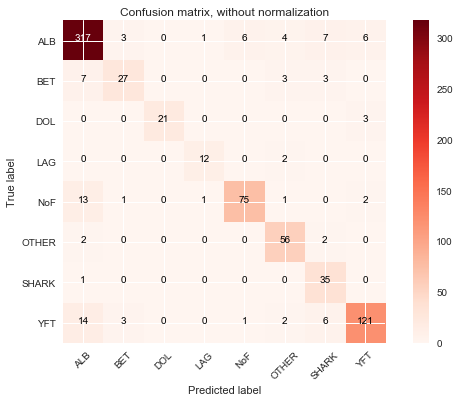

In [213]:
plt.figure()
plot_confusion_matrix(cf, classes=classes,
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[ 0.92  0.01  0.    0.    0.02  0.01  0.02  0.02]
 [ 0.18  0.68  0.    0.    0.    0.08  0.08  0.  ]
 [ 0.    0.    0.88  0.    0.    0.    0.    0.12]
 [ 0.    0.    0.    0.86  0.    0.14  0.    0.  ]
 [ 0.14  0.01  0.    0.01  0.81  0.01  0.    0.02]
 [ 0.03  0.    0.    0.    0.    0.93  0.03  0.  ]
 [ 0.03  0.    0.    0.    0.    0.    0.97  0.  ]
 [ 0.1   0.02  0.    0.    0.01  0.01  0.04  0.82]]


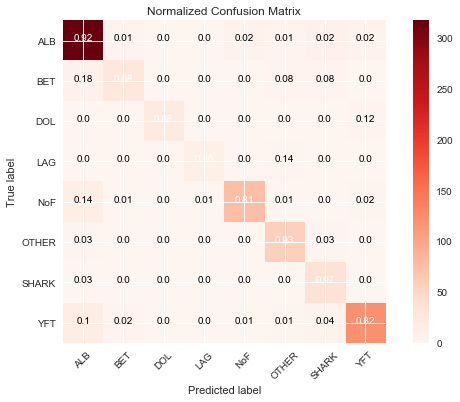

In [214]:
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cf, classes=classes, normalize = True, title= "Normalized Confusion Matrix"
                      )
plt.show()

In [218]:
sum(valid_labels==new_labels)

664

In [219]:
758-664

94

In [223]:
correct_labels = (valid_labels == new_labels)

In [265]:
incorrect_indexes = np.where(correct_labels==False)[0]
correct_indexes = np.where(correct_labels == True)[0]

In [255]:
valid_paths = []
for c in classes:
    valid_paths.extend(["new_valid/"+c+'/'+name for name in os.listdir("new_valid/"+c+'/')])

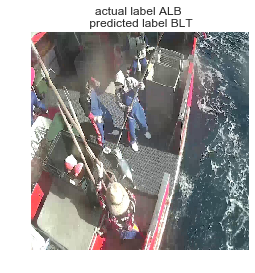

In [263]:
from keras.preprocessing import image
img_path = valid_paths[0]
img = image.load_img(img_path,target_size=(224,224))
plt.title("actual label {} \n predicted label {}".format('ALB','BLT'))
plt.axis("off")
plt.imshow(img)

In [276]:
correct_samples = np.random.choice(correct_indexes,size=5)

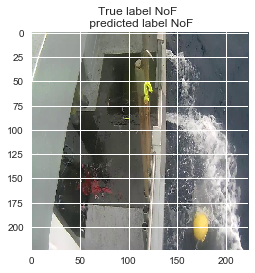

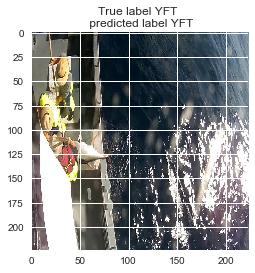

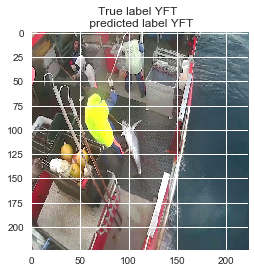

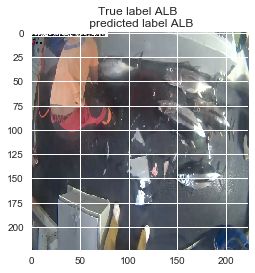

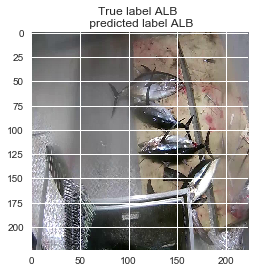

In [292]:
for i,sample in enumerate(correct_samples):
    img = image.load_img(valid_paths[sample],target_size = (224,224))
    fig = plt.figure()
    plt.title("True label {} \n predicted label {}".format(valid_labels[sample],new_labels[sample]))
    plt.imshow(img)
    

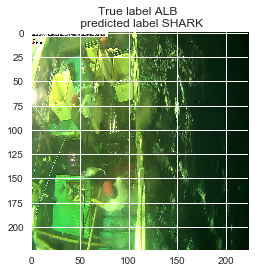

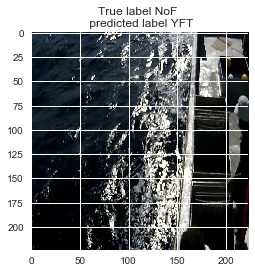

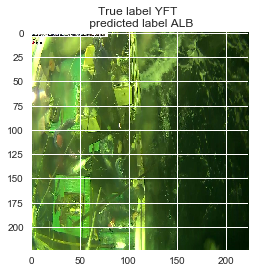

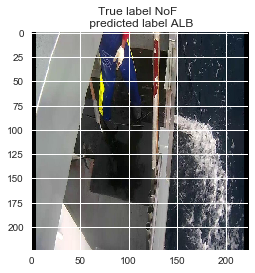

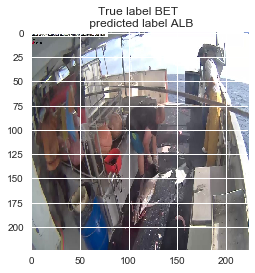

In [294]:
incorrect_samples = np.random.choice(incorrect_indexes,size = 5)
for i,sample in enumerate(incorrect_samples):
    img = image.load_img(valid_paths[sample],target_size = (224,224))
    fig = plt.figure()
    plt.title("True label {} \n predicted label {}".format(valid_labels[sample],new_labels[sample]))
    plt.imshow(img)
    

In [297]:
np_valid_preds.round(2)

array([[ 0.08,  0.8 ,  0.  , ...,  0.  ,  0.  ,  0.12],
       [ 1.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.19,  0.01,  0.01, ...,  0.25,  0.44,  0.02],
       ..., 
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  1.  ],
       [ 0.47,  0.01,  0.04, ...,  0.02,  0.29,  0.14],
       [ 0.22,  0.  ,  0.04, ...,  0.02,  0.53,  0.15]], dtype=float32)

In [298]:
from sklearn.metrics import log_loss

In [299]:
log_loss(valid_labels,np_valid_preds.round(2))

1.0071659829887736

In [300]:
test_features = np.load("test_preprocessed.npy")
test_preds = vgg16_model.predict(test_features, batch_size=5, verbose=1)


1000/1000 [==============================] - 739s      

In [302]:
np.clip(test_preds.round(2),

array([[ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.19,  0.31,  0.02, ...,  0.39,  0.06,  0.  ],
       [ 0.95,  0.02,  0.  , ...,  0.03,  0.  ,  0.  ],
       ..., 
       [ 0.31,  0.  ,  0.  , ...,  0.63,  0.  ,  0.01],
       [ 1.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.01,  0.01,  0.  , ...,  0.92,  0.03,  0.01]], dtype=float32)

In [303]:
submission1 = pd.DataFrame(test_preds.round(2), columns= os.listdir(train_dir))
test_files = os.listdir("test_stg1/test_stg1/")
submission1.insert(0, 'image', test_files)
submission1.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_00005.jpg,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
1,img_00007.jpg,0.19,0.31,0.02,0.03,0.01,0.39,0.06,0.00
2,img_00009.jpg,0.95,0.02,0.00,0.00,0.00,0.03,0.00,0.00
3,img_00018.jpg,0.34,0.00,0.00,0.00,0.00,0.65,0.00,0.00
4,img_00027.jpg,0.54,0.00,0.01,0.01,0.00,0.03,0.26,0.14


In [304]:
submission1.to_csv("final_non_clipped.csv",index=False)

In [305]:
clipped_preds = np.clip(test_preds,(1-0.82)/7,0.88)

submission2 = pd.DataFrame(clipped_preds, columns= os.listdir("train/train/"))
submission2.insert(0, 'image', test_files)
submission2.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_00005.jpg,0.025714,0.025714,0.025714,0.025714,0.880000,0.025714,0.025714,0.025714
1,img_00007.jpg,0.187484,0.307488,0.025714,0.025714,0.025714,0.389250,0.062202,0.025714
2,img_00009.jpg,0.880000,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714
3,img_00018.jpg,0.344736,0.025714,0.025714,0.025714,0.025714,0.649582,0.025714,0.025714
4,img_00027.jpg,0.538186,0.025714,0.025714,0.025714,0.025714,0.033254,0.260934,0.142984


In [306]:
submission2.to_csv("final_clipped.csv",index=False)

In [307]:
correct_samples

array([492, 644, 665,  57, 126], dtype=int64)

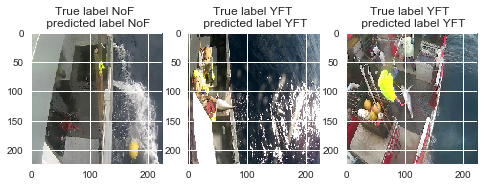

In [313]:
fig = plt.figure(figsize=(8,10))

fig.add_subplot(1,3,1)
sample = correct_samples[0]
img = image.load_img(valid_paths[sample],target_size = (224,224))
plt.title("True label {} \n predicted label {}".format(valid_labels[sample],new_labels[sample]))
plt.imshow(img)
fig.add_subplot(1,3,2)
sample = correct_samples[1]
img = image.load_img(valid_paths[sample],target_size = (224,224))
plt.title("True label {} \n predicted label {}".format(valid_labels[sample],new_labels[sample]))
plt.imshow(img)
fig.add_subplot(1,3,3)
sample = correct_samples[2]
img = image.load_img(valid_paths[sample],target_size = (224,224))
plt.title("True label {} \n predicted label {}".format(valid_labels[sample],new_labels[sample]))
plt.imshow(img)
fig.add_subplot(1,3,3)
sample = correct_samples[2]
img = image.load_img(valid_paths[sample],target_size = (224,224))
plt.title("True label {} \n predicted label {}".format(valid_labels[sample],new_labels[sample]))
plt.imshow(img)

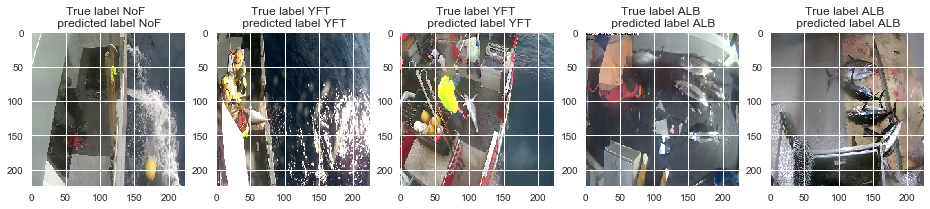

In [320]:
fig = plt.figure(figsize=(16,12))
for i,sample in enumerate(correct_samples):
    fig.add_subplot(1,5,i+1)
    img = image.load_img(valid_paths[sample],target_size = (224,224))
    plt.title("True label {} \n predicted label {}".format(valid_labels[sample],new_labels[sample]))
    plt.imshow(img)
    

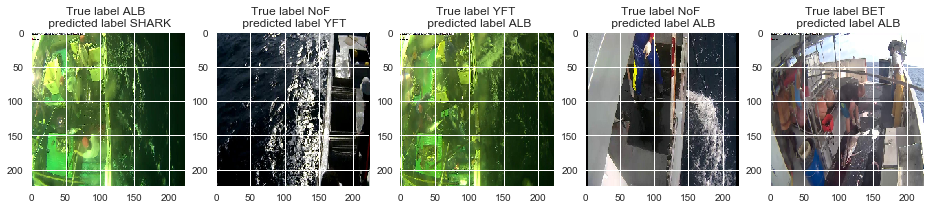

In [321]:
fig = plt.figure(figsize=(16,12))
for i,sample in enumerate(incorrect_samples):
    fig.add_subplot(1,5,i+1)
    img = image.load_img(valid_paths[sample],target_size = (224,224))
    plt.title("True label {} \n predicted label {}".format(valid_labels[sample],new_labels[sample]))
    plt.imshow(img)
    